In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline

In [2]:
# print([np.random.binomial(n=80, p=0.5, size=(int(20 * 0.005 * 1e6),)).max() for _ in range(5)])
# print([np.random.binomial(n=80, p=0.5, size=(int(1000 * 0.005 * 1e6),)).max() for _ in range(5)])
# print([np.random.binomial(n=80, p=0.5, size=(int(20_000 * 0.005 * 1e6),)).max() for _ in range(5)])

In [3]:
n_train_steps = int(1e6)
replacement_rate = 0.005
device = 'cuda' # 'cpu'

n_inputs = 80
n_target_features = 20
n_learn_features = 20_480
n_original_learn_features = n_learn_features
n_samples = 100_000
n_runs = 5

assert n_learn_features % n_target_features == 0

# # Reinitialize input weights based on an optimistic estnimation of what is possible after n_train_steps
# n_features_tested = int(n_train_steps * replacement_rate * n_original_learn_features)

# # Sample from binomial distribution with n=80 trials and p=0.5
# possible_hits = np.random.binomial(n=n_inputs, p=0.5, size=(n_features_tested,))

# # Use the results to set the learned input weights to roughly the best possible features that
# # were likely to have been found after n_train_steps
# max_hits = possible_hits.max()
max_hits = 65
n_misses = n_inputs - max_hits

In [12]:
def run_single_trial(
    n_inputs,
    n_target_features,
    n_learn_features,
    n_samples,
    n_misses,
    device,
    seed = None,
    normalize_targets = False,
):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    # Create target weights
    target_w1 = torch.tensor(
        np.random.choice([-1, 1], size=(n_target_features, n_inputs)),
        device = device,
        dtype = torch.float32,
    )
    target_w2 = torch.tensor(
        np.random.uniform(
            -np.sqrt(3/n_target_features), np.sqrt(3/n_target_features),
            size = (1, n_target_features),
        ),
        device = device,
        dtype = torch.float32,
    )

    # Create input data
    inputs = torch.tensor(np.random.normal(size=(n_samples, n_inputs)), device=device, dtype=torch.float32)

    # Create learned weights initialized differently
    learned_w1 = torch.tensor(
        np.random.choice([-1, 1], size=(n_learn_features, n_inputs)),
        device = device,
        dtype = torch.float32,
    )
    learned_w2 = torch.tensor(
        np.random.uniform(
            -np.sqrt(3/n_learn_features), np.sqrt(3/n_learn_features),
            size = (1, n_learn_features),
        ),
        device = device,
        dtype = torch.float32,
    )

    n_weight_multiple = n_target_features // n_learn_features
    for i in range(n_weight_multiple):
        learned_w1[i*n_target_features:(i+1)*n_target_features, :] = \
            target_w1.clone()
        miss_idxs = torch.tensor(np.random.choice(n_inputs, size=n_misses, replace=False), device=device)
        learned_w1[i*n_target_features:(i+1)*n_target_features, miss_idxs] = \
            -learned_w1[i*n_target_features:(i+1)*n_target_features, miss_idxs]

    # Calculate targets
    targets = target_w2 @ ((target_w1 @ inputs.T) > 0).float()
    targets = targets.squeeze()
    
    if normalize_targets:
        targets -= targets.mean()
        targets /= targets.std()

    # Split into train and test sets
    train_inputs, train_targets = inputs[:n_samples//2], targets[:n_samples//2]
    test_inputs, test_targets = inputs[n_samples//2:], targets[n_samples//2:]

    # Get hidden layer activations
    train_hidden = ((learned_w1 @ train_inputs.T) > 0).float()
    test_hidden = ((learned_w1 @ test_inputs.T) > 0).float()

    # Initialize learning rate and number of epochs
    lr = 0.1 / n_learn_features**0.75
    n_epochs = 10000
    best_mse = float('inf')
    plateau_count = 0
    
    train_losses = []
    eval_losses = []

    # Train with learning rate decay
    for epoch in tqdm(range(n_epochs)):
        # Compute predictions and error
        train_preds = (learned_w2 @ train_hidden).squeeze()
        error = train_preds - train_targets
        current_mse = torch.mean(error ** 2).item()
        # train_losses.append(current_mse)
        
        # Update weights using gradient descent
        grad = (error @ train_hidden.T) / error.shape[0]
        learned_w2 -= lr * grad.unsqueeze(0)
        
        if epoch % 200 == 0:
            # Compute eval loss
            test_preds = learned_w2 @ test_hidden
            test_mse = torch.mean((test_preds - test_targets) ** 2).item()
            eval_losses.append(test_mse)
            train_losses.append(current_mse)
            print(f"Epoch {epoch} | Train MSE: {current_mse:.4f} | Test MSE: {test_mse:.4f} | LR: {lr:.4f}")
        
        # Decay learning rate if MSE hasn't improved
        if current_mse >= best_mse:
            plateau_count += 1
            if plateau_count >= 5 and lr > 0.00001:  # After 5 epochs without improvement
                lr *= 0.5
                plateau_count = 0
        else:
            best_mse = current_mse
            plateau_count = 0

    # Final eval
    test_preds = learned_w2 @ test_hidden
    test_mse = torch.mean((test_preds - test_targets) ** 2).item()
    eval_losses.append(test_mse)
    train_losses.append(current_mse)
    
    return train_losses, eval_losses

In [13]:
# # Run multiple trials
# test_mses = []
# for run in range(n_runs):
#     test_mse = run_single_trial(n_inputs, n_target_features, n_learn_features, n_samples, n_misses, device)
#     test_mses.append(test_mse)
#     print(f"Run {run + 1} Test MSE: {test_mse:.4f}")

# mean_mse = np.mean(test_mses)
# print(f"\nMean Test MSE across {n_runs} runs: {mean_mse:.4f}")


In [14]:
# Is it overfitting?

In [15]:
# train_results_1k, eval_results_1k = run_single_trial(
#     n_inputs, n_target_features, 1240, n_samples, n_misses, device, seed=792025, normalize_targets=False)

In [17]:
train_results_20k, eval_results_20k = run_single_trial(
    n_inputs, n_target_features, 20_480, n_samples, n_misses, device, seed=792025, normalize_targets=False)

  0%|          | 1/10000 [00:09<25:43:03,  9.26s/it]

Epoch 0 | Train MSE: 0.6031 | Test MSE: 0.5362 | LR: 0.0001


  2%|▏         | 201/10000 [02:53<3:09:55,  1.16s/it]

Epoch 200 | Train MSE: 0.2964 | Test MSE: 0.2964 | LR: 0.0001


  4%|▍         | 401/10000 [05:36<3:07:23,  1.17s/it]

Epoch 400 | Train MSE: 0.2255 | Test MSE: 0.2263 | LR: 0.0001


  6%|▌         | 601/10000 [08:18<2:52:18,  1.10s/it]

Epoch 600 | Train MSE: 0.1982 | Test MSE: 0.1993 | LR: 0.0001


  8%|▊         | 801/10000 [11:02<2:58:42,  1.17s/it]

Epoch 800 | Train MSE: 0.1875 | Test MSE: 0.1887 | LR: 0.0001


 10%|█         | 1001/10000 [13:45<2:53:36,  1.16s/it]

Epoch 1000 | Train MSE: 0.1831 | Test MSE: 0.1844 | LR: 0.0001


 12%|█▏        | 1201/10000 [16:28<2:49:31,  1.16s/it]

Epoch 1200 | Train MSE: 0.1812 | Test MSE: 0.1826 | LR: 0.0001


 14%|█▍        | 1401/10000 [19:11<2:46:58,  1.17s/it]

Epoch 1400 | Train MSE: 0.1803 | Test MSE: 0.1818 | LR: 0.0001


 16%|█▌        | 1601/10000 [21:56<2:42:08,  1.16s/it]

Epoch 1600 | Train MSE: 0.1797 | Test MSE: 0.1813 | LR: 0.0001


 18%|█▊        | 1801/10000 [24:40<2:16:19,  1.00it/s]

Epoch 1800 | Train MSE: 0.1792 | Test MSE: 0.1810 | LR: 0.0001


 20%|██        | 2001/10000 [27:25<2:31:47,  1.14s/it]

Epoch 2000 | Train MSE: 0.1789 | Test MSE: 0.1808 | LR: 0.0001


 22%|██▏       | 2201/10000 [30:08<2:30:54,  1.16s/it]

Epoch 2200 | Train MSE: 0.1785 | Test MSE: 0.1805 | LR: 0.0001


 24%|██▍       | 2401/10000 [32:52<2:27:51,  1.17s/it]

Epoch 2400 | Train MSE: 0.1782 | Test MSE: 0.1803 | LR: 0.0001


 26%|██▌       | 2601/10000 [35:36<2:24:24,  1.17s/it]

Epoch 2600 | Train MSE: 0.1778 | Test MSE: 0.1802 | LR: 0.0001


 28%|██▊       | 2801/10000 [38:20<2:20:07,  1.17s/it]

Epoch 2800 | Train MSE: 0.1775 | Test MSE: 0.1800 | LR: 0.0001


 30%|███       | 3001/10000 [41:03<2:15:19,  1.16s/it]

Epoch 3000 | Train MSE: 0.1771 | Test MSE: 0.1798 | LR: 0.0001


 30%|███       | 3039/10000 [41:35<1:35:16,  1.22it/s]


KeyboardInterrupt: 

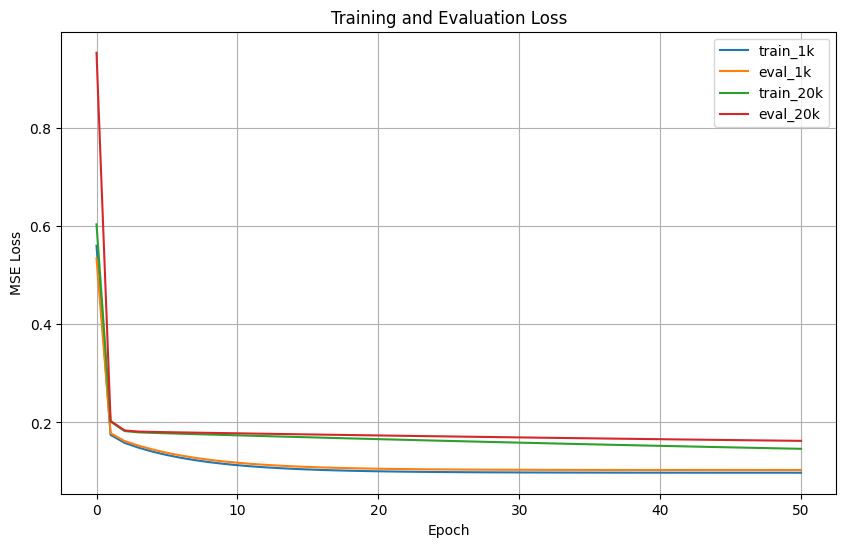

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_results_1k, label='train_1k')
plt.plot(eval_results_1k, label='eval_1k') 
plt.plot(train_results_20k, label='train_20k')
plt.plot(eval_results_20k, label='eval_20k')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Does having multiple different approximations of one feature in the target network help?

In other words, is there any benefit to having multiple imperfect features instead of just one imperfect feature if each is imperfect in a different way?

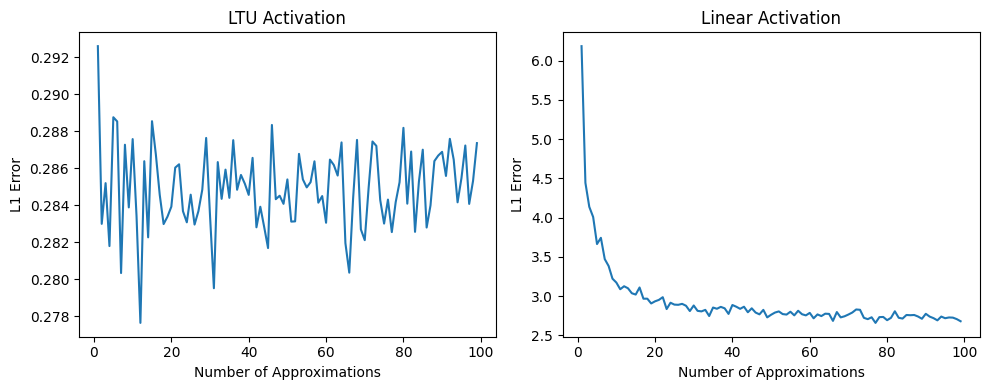

In [ ]:
n_inputs = 80
# n_features = 20
n_correct = 65
# n_approximations = 1000


def activation_fn(x):
    return x
    # return np.maximum(x, 0)
    return (x > 0).astype(float)

prediction_errors_list = []
n_approximations_list = list(range(1, 100))

target_weights = np.random.randint(0, 2, size=(n_inputs,)) * 2 - 1

ltu_activation_fn = lambda x: (x > 0).astype(float)
linear_activation_fn = lambda x: x

def run_approximation_experiment(activation_fn):
    prediction_errors_list = []
    for n_approximations in n_approximations_list:
        approx_weights = np.empty(shape=(n_approximations, n_inputs))

        for i in range(n_approximations):
            approx_weights[i, :] = target_weights[:]
            incorrect_idxs = np.random.choice(n_inputs, size=n_inputs - n_correct, replace=False)
            approx_weights[i, incorrect_idxs] = -approx_weights[i, incorrect_idxs]

        sample_inputs = np.random.randn(5000, n_inputs)

        real_outputs = activation_fn(sample_inputs @ target_weights).astype(float)
        approx_outputs = activation_fn(sample_inputs @ approx_weights.T).astype(float) # (n_samples, n_approximations)

        output_predictions = approx_outputs.mean(axis=1).astype(float)

        prediction_errors = output_predictions - real_outputs
        l1_error = np.abs(prediction_errors).mean()
        
        prediction_errors_list.append(l1_error)
    
    return n_approximations_list, prediction_errors_list

# Run experiments with both activation functions
ltu_results = run_approximation_experiment(ltu_activation_fn)
linear_results = run_approximation_experiment(linear_activation_fn)
# Plot results
plt.figure(figsize=(10, 4))

plt.suptitle('Feature Approximation Error')

plt.subplot(121)
plt.plot(ltu_results[0], ltu_results[1])
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('LTU Activation')

plt.subplot(122)
plt.plot(linear_results[0], linear_results[1])
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error') 
plt.title('Linear Activation')

plt.tight_layout()
plt.show()
